In [2]:
import torch

自动微分

In [21]:
x=torch.arange(4.0,requires_grad=True)
print(x)
x.grad

tensor([0., 1., 2., 3.], requires_grad=True)


In [16]:
y=2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

In [17]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [27]:
x.grad.zero_()
y=x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [33]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y=x*x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [38]:
x.grad.zero_()
y=x*x
u=y.detach()
z=u*x
z.sum().backward()
x.grad

tensor([0., 1., 4., 9.])

In [39]:
x.grad.zero_()
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [59]:
def f(a):
    b=a*2
    while b.norm()<1000:
        b=b*2
    if b.sum()>0:
        c=b
    else:
        c=100*b
    return c

a=torch.randn(size=(),requires_grad=True)
d=f(a)
d.backward()
a.grad==d/a

tensor(True)

线性回归

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import torch

In [63]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [64]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()


In [70]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.08092 sec'

In [82]:
timer.start()
d = a + b
f'{timer.stop():.8f} sec'

'0.00100088 sec'

线性回归实现


In [4]:
%matplotlib inline
import random
import torch

In [5]:
def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [9]:
print('features:', features[0],'\nlabel:', labels[0])


features: tensor([-0.3069, -0.4951]) 
label: tensor([5.2741])


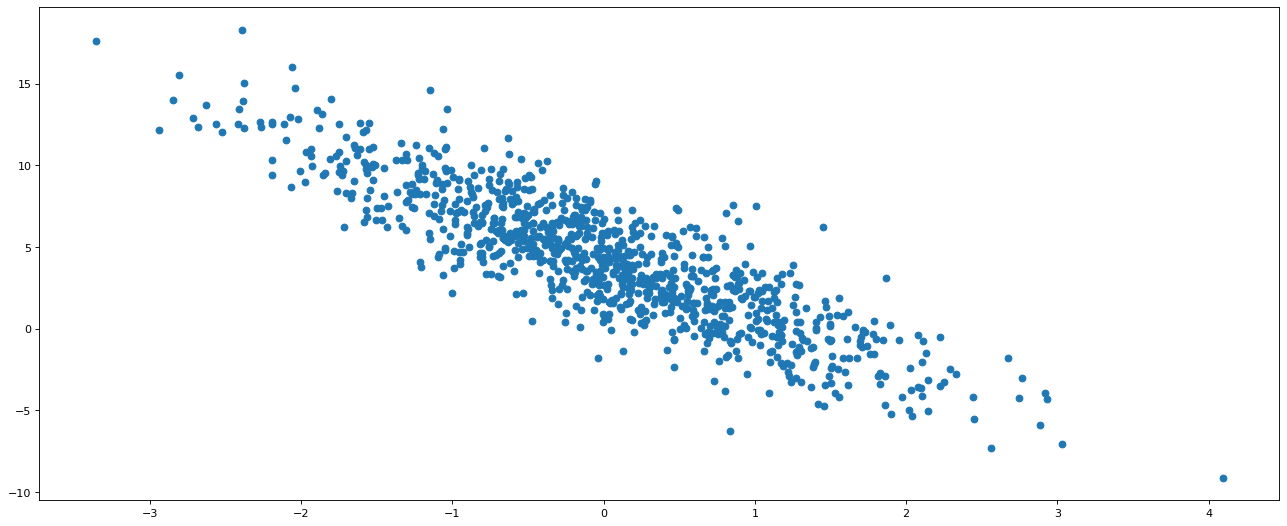

In [12]:
plt.figure(figsize=(20,8),dpi=80)
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy())

In [32]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [34]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7567,  0.3593],
        [-0.0126,  2.4050],
        [ 2.1412,  0.7890],
        [-0.4965,  0.5478],
        [ 2.0338, -2.1480],
        [ 2.1730,  1.0185],
        [ 1.0430, -0.0721],
        [ 0.6900, -0.1905],
        [ 0.1100,  0.0808],
        [ 0.8355, -1.4072]]) 
 tensor([[ 4.5031],
        [-4.0184],
        [ 5.8040],
        [ 1.3548],
        [15.5736],
        [ 5.0808],
        [ 6.5130],
        [ 6.2196],
        [ 4.1591],
        [10.6605]])


In [35]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


In [36]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [17]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [31]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [29]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [37]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        # print(l)
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033163
epoch 2, loss 0.000111
epoch 3, loss 0.000050


In [28]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0008, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)


线性回归的简洁实现

In [5]:
import numpy as np
from torch.utils import data


In [6]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features,labels=synthetic_data(true_w,true_b,1000)

In [10]:
def load_array(data_arrays,batch_size,is_train=True):
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

In [12]:
batch_size=10
data_iter=load_array((features,labels),batch_size)
next(iter(data_iter))

[tensor([[ 1.2308,  0.4737],
         [ 0.9727,  0.3447],
         [-0.5008,  1.0313],
         [-0.5131, -0.9648],
         [-0.5625,  0.8303],
         [-0.9906,  0.2793],
         [ 0.5746,  2.6055],
         [ 1.5640,  0.4319],
         [-1.8685,  2.3845],
         [ 1.3845, -0.0088]]),
 tensor([[ 5.0537],
         [ 4.9656],
         [-0.3181],
         [ 6.4691],
         [ 0.2313],
         [ 1.2610],
         [-3.5157],
         [ 5.8551],
         [-7.6392],
         [ 6.9971]])]

In [13]:
from torch import nn

In [15]:
net=nn.Sequential(nn.Linear(2,1))

In [16]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [17]:
loss=nn.MSELoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.03)

In [18]:
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000245
epoch 2, loss 0.000103
epoch 3, loss 0.000103


In [19]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0005, -0.0004])
b的估计误差： tensor([0.0003])


图像分类数据集

In [15]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import time

In [7]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
root="../data", train=False, transform=trans, download=True)


100.0%
100.0%
100.0%
100.0%


In [8]:
len(mnist_train), len(mnist_test)


(60000, 10000)

In [9]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [25]:
def get_fashion_mnist_labels(labels): 
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [6]:
batch_size=256

def get_dataloader_workers():
    return 4

train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())



NameError: name 'mnist_train' is not defined

In [31]:
t1=time.time()
for X,y in train_iter:
    continue
t2=time.time()
t2-t1

3.883678436279297

In [3]:
def load_data_fashion_mnist(batch_size, resize=None):
     """下载Fashion-MNIST数据集，然后将其加载到内存中"""
     trans = [transforms.ToTensor()]
     if resize:
        trans.insert(0, transforms.Resize(resize))
     trans = transforms.Compose(trans)
     mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
     mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
     return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers()),
             data.DataLoader(mnist_test, batch_size, shuffle=False,
                             num_workers=get_dataloader_workers()))

In [27]:
train_iter,test_iter=load_data_fashion_mnist(32,resize=64)
for X,y in train_iter:
    print(X.shape,X.dtype,y.shape,y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


softmax回归的从零开始实现

In [16]:
import torch
from IPython import display
from d2l import torch as d2l



In [5]:
batch_size = 256
def get_dataloader_workers():
    return 4
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [6]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


In [7]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制


In [14]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0712, 0.2687, 0.4119, 0.0328, 0.2154],
         [0.0954, 0.4758, 0.2879, 0.0324, 0.1085]]),
 tensor([1.0000, 1.0000]))

In [8]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W)+b)

In [9]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

In [12]:
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype)==y
    return float(cmp.type(y.dtype).sum())

In [10]:
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]


In [13]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric=Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [27]:
evaluate_accuracy(net,test_iter)

0.0749

In [13]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [14]:
lr = 0.1
def updater(batch_size):
    return sgd([W, b], lr, batch_size)

In [7]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    metric=Accumulator(3)
    for X,y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            #内置的
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            #自定的
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


In [6]:
class Animator: #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [8]:
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics=train_epoch_ch3(net,train_iter,loss,updater)
        test_acc=evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
    train_loss,train_acc=train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
 

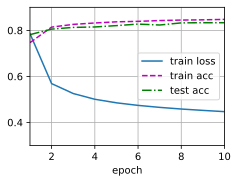

<Figure size 640x480 with 0 Axes>

In [18]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


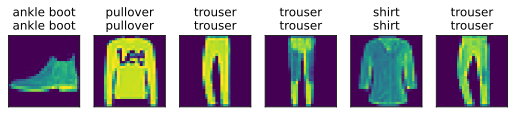

In [19]:
def predict_ch3(net, test_iter, n=6): #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)


softmax的简单实现

In [18]:
import torch
from torch import nn
from d2l import torch as d2l

In [19]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [20]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [21]:
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

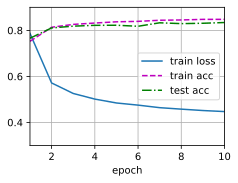

In [22]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

多层感知机

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1=nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True)*0.01)
b1=nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2=nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2=nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params=[W1,b1,W2,b2]

In [4]:
def relu(X):
    a=torch.zeros_like(X)
    return torch.max(X,a)

In [5]:
def net(X):
    X=X.reshape((-1,num_inputs))
    H=relu(X@W1+b1)
    return (H@W2+b2)

In [6]:
loss=nn.CrossEntropyLoss(reduction='none')

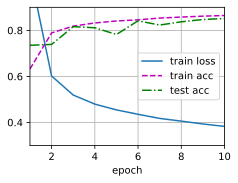

In [7]:
num_epochs,lr=10,0.1
updater=torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)

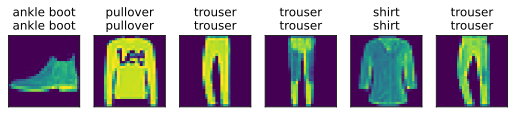

In [8]:
d2l.predict_ch3(net, test_iter)

简洁实现

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

In [12]:
net=nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),nn.Linear(256,10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

In [13]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

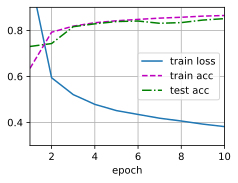

In [14]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

模型选择，过拟合和欠拟合

In [15]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [16]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [17]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [18]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [19]:
def train(train_features, test_features, train_labels, test_labels,num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
    batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
    batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
    xlim=[1, num_epochs], ylim=[1e-3, 1e2],
    legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9805574  1.2419499 -3.4013913  5.523183 ]]


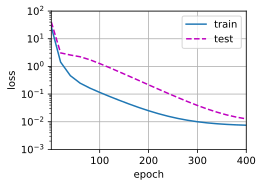

In [21]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],labels[:n_train], labels[n_train:])

weight: [[3.5329332 4.128181 ]]


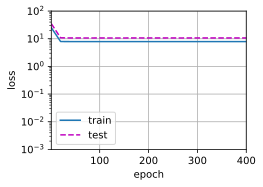

In [22]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
labels[:n_train], labels[n_train:])

weight: [[ 4.938357    1.2955729  -3.1659558   5.188417   -0.6643348   0.8096834
   0.16715081  0.28508008  0.10560061 -0.03585716 -0.21186925 -0.05526981
   0.1448356  -0.1531217  -0.11279483  0.09637407 -0.14463493 -0.09321925
   0.07020906  0.02496305]]


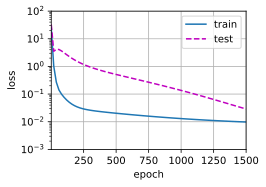

In [23]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:], num_epochs=1500)

权重衰退

In [26]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [27]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [28]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [29]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [30]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
    xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 14.292427062988281


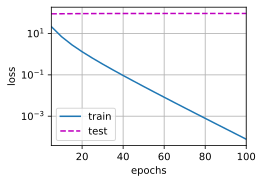

In [31]:
train(lambd=0)

w的L2范数是： 0.37880343198776245


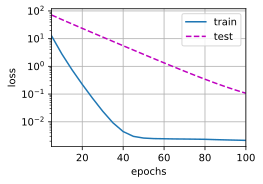

In [32]:
train(lambd=3)

In [33]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
    {"params":net[0].weight,'weight_decay': wd},
    {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
    xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
            (d2l.evaluate_loss(net, train_iter, loss),
            d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())


w的L2范数： 12.37634563446045


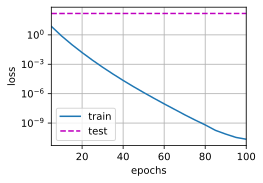

In [34]:
train_concise(0)

w的L2范数： 0.4217044413089752


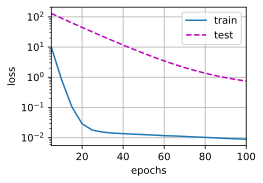

In [35]:
train_concise(3)

Dropout

In [36]:
import torch
from torch import nn
from d2l import torch as d2l
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [37]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [38]:
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
    is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

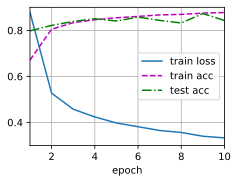

In [39]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [40]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);


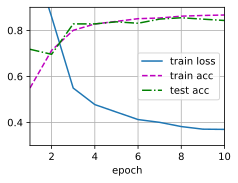

In [41]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)